# Version of DogFaceNet implementation for MNIST dataset
We will train to stick on the pairs learning technique

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

### Dataset implementation

Load the dataset

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
SIZE = (28,28)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

Create the pairs

In [3]:
# check some pairs
s = 20
n = 5
print(issame[2*s:(n+s)*2])
#print(y_pairs[2*s:(n+s)*2])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i])
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1])

NameError: name 'issame' is not defined

In [ ]:
nbof_pairs = len(y_train)*2

pairs = np.empty((nbof_pairs,28,28))
issame = np.empty(nbof_pairs)

for i in tqdm_notebook(range(0,nbof_pairs,2)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(10)
        class2 = np.random.randint(10)
        while class1==class2:
            class2 = np.random.randint(10)
            
        # Extract images of this class:
        y_class1 = np.arange(len(y_train))[np.equal(y_train,class1)]
        y_class2 = np.arange(len(y_train))[np.equal(y_train,class2)]
        
        # Chose an image amoung these selected images
        pairs[i] = x_train[y_class1[np.random.randint(len(y_class1))]]
        pairs[i+1] = x_train[y_class2[np.random.randint(len(y_class2))]]
        issame[i] = issame[i+1] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(10)
        y_class = np.arange(len(y_train))[np.equal(y_train,clas)]
        
        # Select two images from this class
        idx_image1 = y_class[np.random.randint(len(y_class))]
        idx_image2 = y_class[np.random.randint(len(y_class))]
        while idx_image1 == idx_image2:
            idx_image2 = y_class[np.random.randint(len(y_class))]
        
        pairs[i] = x_train[idx_image1]
        pairs[i+1] = x_train[idx_image2]
        issame[i] = issame[i+1] = 1


Create the triplets

In [3]:
nbof_triplets = len(y_train)*3

triplets = np.empty((nbof_triplets,28,28))
y_triplets = np.empty(nbof_triplets)
issame = np.empty(nbof_triplets)

for i in tqdm_notebook(range(0,nbof_triplets,3)):
    # Pair of same classes
    # Chose a class
    clas = np.random.randint(10)
    y_class = np.arange(len(y_train))[np.equal(y_train,clas)]

    # Select two images from this class
    idx_image1 = y_class[np.random.randint(len(y_class))]
    idx_image2 = y_class[np.random.randint(len(y_class))]
    while idx_image1 == idx_image2:
        idx_image2 = y_class[np.random.randint(len(y_class))]

    triplets[i] = x_train[idx_image1]
    triplets[i+1] = x_train[idx_image2]
    issame[i] = issame[i+1] = 1
    y_triplets[i] = y_triplets[i+1] = clas

    # Pair of different classes
    # Chose the classes:
    class2 = np.random.randint(10)
    while clas==class2:
        class2 = np.random.randint(10)

    # Extract images of this class:
    y_class2 = np.arange(len(y_train))[np.equal(y_train,class2)]

    # Chose an image amoung these selected images
    triplets[i+2] = x_train[y_class2[np.random.randint(len(y_class2))]]
    issame[i+2] = 0
    y_triplets[i+2] = class2


HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

[1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
[8. 8. 6. 1. 1. 0. 8. 8. 3. 9. 9. 2. 2. 2. 6.]


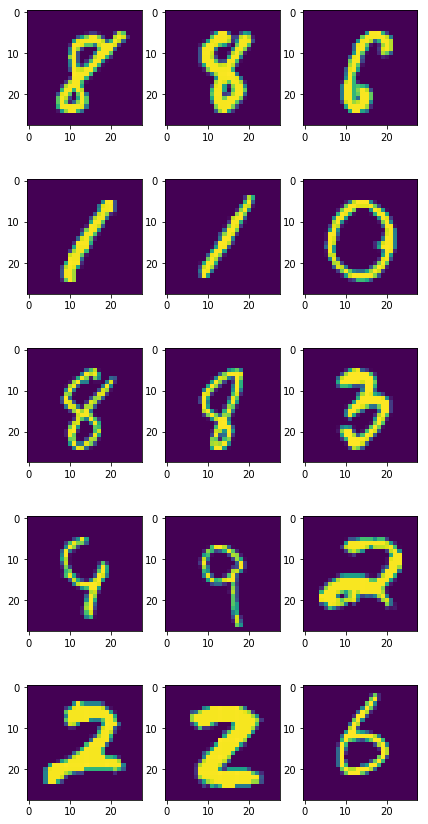

In [14]:
# Check some triplets
s = 10
n = 5
print(issame[3*s:(n+s)*3])
print(y_triplets[3*s:(n+s)*3])
fig = plt.figure(figsize=(7,3*n))
for i in range(s,s+n):
    plt.subplot(n,3,3*(i-s)+1)
    plt.imshow(triplets[3*i])
    plt.subplot(n,3,3*(i-s)+2)
    plt.imshow(triplets[3*i+1])
    plt.subplot(n,3,3*(i-s)+3)
    plt.imshow(triplets[3*i+2])

In [4]:
triplets_exp = np.expand_dims(triplets, -1)
triplets_exp.shape

(180000, 28, 28, 1)

### Define the loss

In [6]:
import tensorflow.keras.backend as K
alpha = 0.3
def triplet(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p), axis = -1)
    an = K.sum(K.square(a-n), axis = -1)
    s = K.sum(tf.nn.relu(ap - an + alpha))
    return s

In [10]:
import tensorflow.keras.backend as K
alpha = 0.3
def cosine(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    cos_ap = K.sum(a*p, axis = -1)
    cos_an = K.sum(a*n, axis = -1)
    s = K.sum(tf.nn.relu(cos_ap - cos_an + alpha))
    return K.sum(s)

In [47]:
c = np.vstack([0,2,1,2])
np.hstack([c,c])

array([[0, 0],
       [2, 2],
       [1, 1],
       [2, 2]])

[array([[1.1920933e-07, 1.2321234e+00, 1.7452331e+00, 2.5488794e+00],
       [1.2321234e+00, 1.1920933e-07, 1.2362516e+00, 8.3615243e-02],
       [1.7452331e+00, 1.2362516e+00, 1.1920933e-07, 5.6087297e-01],
       [2.5488794e+00, 8.3615243e-02, 5.6087297e-01, 1.1920933e-07]],
      dtype=float32)]


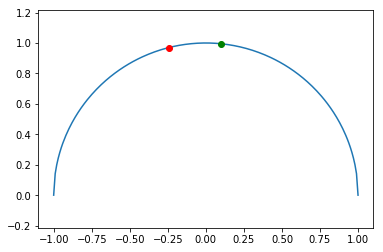

In [83]:
# Exploration with numpy
_y_pred = np.array([[-0.25,1],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.],[-1,0.1]], dtype=np.float32)
_y_true = [0,1,1,1]
_y_pred_norm = _y_pred/np.linalg.norm(_y_pred, axis=-1, keepdims=True)
_classes = tf.keras.utils.to_categorical(_y_true,3)
_centers = np.transpose(_y_pred_norm.T.dot(_classes / (np.sum(_classes, axis=0, keepdims=True)+1)))
#_centers_norm = _centers/np.linalg.norm(_centers, axis=-1, keepdims=True)
x = np.linspace(-1,1,200)
plt.axis('equal')
plt.plot(x,np.sqrt(1.-np.square(x)))
colors = ['r','g','b']
for i in range(3):
    plt.plot(_centers_norm[i,0],_centers_norm[i,1],colors[i]+'o')

    
# Exploration with tensorflow
y_pred = tf.constant(_y_pred)
c = np.vstack(_y_true)
y = np.hstack([c,c])
y_true = tf.constant(y)

y_pred = y_pred / tf.norm(y_pred, axis=-1, keepdims=True)

extract = tf.cast(y_true[:,0], dtype=tf.int32)
classes = tf.one_hot(extract,depth=3)
classes = tf.cast(classes, dtype=tf.float32)

# Simulation into the loss function:
dot_y_pred = K.dot(y_pred,K.transpose(y_pred))
is_same_mask = K.dot(classes,K.transpose(classes))

out = K.binary_crossentropy(is_same_mask,dot_y_pred*0.5+0.5)

# same = (dot_y_pred * 0.5 + 0.5) * is_same_mask
# reshape_same = tf.reshape(same,[-1])

# is_not_same_mask = 1. - is_same_mask
# not_same = (dot_y_pred * -0.5 + 0.5) * is_not_same_mask
# reshape_not_same = tf.reshape(not_same,[-1])

# concat_pred = tf.concat([reshape_same,reshape_not_same],axis=0)
# concat_true = tf.concat([tf.reshape(is_same_mask,[-1]),tf.reshape(is_not_same_mask,[-1])], axis=0)
# out = K.binary_crossentropy(concat_true, concat_pred)

with tf.Session() as sess:
    print(sess.run([out]))

c:\users\guillaume\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[array([[2., 4., 1.]], dtype=float32), array([-2.5000005 , -0.99753946,  0.72142017, -2.377534  ], dtype=float32), array([0.07585815, 0.26942548, 0.67291963, 0.08490197], dtype=float32), 1.1031052, 1.4880667]


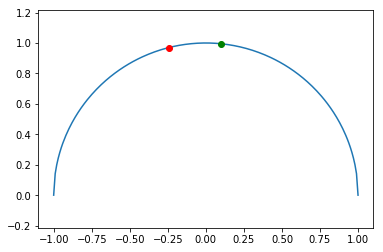

In [18]:
# Exploration with numpy
_y_pred = np.array([[-0.25,1],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.]], dtype=np.float32)
#_y_pred = np.array([[1,2],[5,4],[-1,.5],[1,3.],[-1,0.1]], dtype=np.float32)
_y_true = [0,1,1,1]
_y_pred_norm = _y_pred/np.linalg.norm(_y_pred, axis=-1, keepdims=True)
_classes = tf.keras.utils.to_categorical(_y_true,3)
_centers = np.transpose(_y_pred_norm.T.dot(_classes / np.sum(_classes, axis=0, keepdims=True)))
_centers_norm = _centers/np.linalg.norm(_centers, axis=-1, keepdims=True)
x = np.linspace(-1,1,200)
plt.axis('equal')
plt.plot(x,np.sqrt(1.-np.square(x)))
colors = ['r','g','b']
for i in range(3):
    plt.plot(_centers_norm[i,0],_centers_norm[i,1],colors[i]+'o')
#plt.plot(_y_pred[:,0], _y_pred[:,1], 'go')

# Exploration with tensorflow
y_pred = tf.constant(_y_pred)
c = np.vstack(_y_true)
y = np.hstack([c,c])
y_true = tf.constant(y)


# Simulation into the loss function:
pred = y_pred / tf.norm(y_pred, axis=-1, keepdims=True)

extract = tf.cast(y_true[:,0], dtype=tf.int32)
classes = tf.one_hot(extract,depth=3)
classes = tf.cast(classes, dtype=tf.float32)
den_classes = K.sum(classes, axis=0, keepdims=True) + 1.
centers = K.transpose(K.dot(K.transpose(pred), classes / den_classes))
centers = tf.math.l2_normalize(centers,axis=-1)
centers_classes = K.dot(classes, centers)
ones = (K.sum(centers_classes * pred, axis=-1) * -1. + .5)*5
inter = K.sigmoid(ones)
dist = K.sum(inter)

identity = K.arange(0,3)
identity = tf.one_hot(identity,3)

gram = K.dot(centers,K.transpose(centers)) * 0.5 + 0.5
dev = K.sum(K.pow(gram-identity,10))
with tf.Session() as sess:
    print(sess.run([den_classes,ones,inter,dist,dev]))

In [25]:
import tensorflow.keras.backend as K

def robert(y_true,y_pred):
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    centers = K.transpose(K.dot(K.transpose(y_pred), classes / (K.sum(classes, axis=0, keepdims=True) + 1)))
    centers = tf.math.l2_normalize(centers,axis=-1)
    centers_classes = K.dot(classes, centers)
    
    dist = (K.sum(centers_classes * y_pred, axis=-1) * -1. + .5)*5
    dist = K.sum(K.sigmoid(dist))

    identity = K.arange(0,10)
    identity = tf.one_hot(identity,10)
    
    gram = K.dot(centers,K.transpose(centers)) * 0.5 + 0.5
    dev = K.sum(K.pow(gram-identity,10))
    return dev + dist

In [89]:
def bobby(y_true,y_pred):
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    dot_y_pred = K.dot(y_pred,K.transpose(y_pred))
    is_same_mask = K.dot(classes,K.transpose(classes))

    return K.binary_crossentropy(is_same_mask,dot_y_pred*0.5+0.5)
#     same = (dot_y_pred * 0.5 + 0.5) * is_same_mask
#     reshape_same = tf.reshape(same,[-1])

#     is_not_same_mask = 1. - is_same_mask
#     not_same = (dot_y_pred * -0.5 + 0.5) * is_not_same_mask
#     reshape_not_same = tf.reshape(not_same,[-1])

#     concat_pred = tf.concat([reshape_same,reshape_not_same],axis=0)
#     concat_true = tf.concat([tf.reshape(is_same_mask,[-1]),tf.reshape(is_not_same_mask,[-1])], axis=0)
#     return K.binary_crossentropy(concat_true, concat_pred)

### Define the network

In [30]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Cosine(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [90]:
emb_size = 3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))

model.compile(loss=bobby,
              optimizer='rmsprop'
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
__________

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9216)              0         
__________

In [26]:
x_test.shape

(10000, 28, 28)

In [27]:
x_test = np.expand_dims(x_test,-1)
x_train = np.expand_dims(x_train,-1)

In [67]:
y_train_exp = tf.keras.utils.to_categorical(y_train)
y_test_exp = tf.keras.utils.to_categorical(y_test)

In [91]:
model.fit(x_train,np.dstack([y_train]*2)[0], batch_size=128,epochs=12,validation_data=(x_test,np.dstack([y_test]*2)[0]))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - ETA: 11:59 - loss: 1.44 - ETA: 4:07 - loss: 2.4317 - ETA: 2:33 - loss: 2.415 - ETA: 1:52 - loss: 2.178 - ETA: 1:30 - loss: 2.003 - ETA: 1:15 - loss: 1.944 - ETA: 1:05 - loss: 1.869 - ETA: 58s - loss: 1.799 - ETA: 52s - loss: 1.74 - ETA: 48s - loss: 1.72 - ETA: 44s - loss: 1.70 - ETA: 41s - loss: 1.71 - ETA: 39s - loss: 1.69 - ETA: 36s - loss: 1.68 - ETA: 35s - loss: 1.66 - ETA: 33s - loss: 1.64 - ETA: 31s - loss: 1.64 - ETA: 30s - loss: 1.63 - ETA: 29s - loss: 1.62 - ETA: 28s - loss: 1.61 - ETA: 27s - loss: 1.61 - ETA: 26s - loss: 1.60 - ETA: 25s - loss: 1.60 - ETA: 25s - loss: 1.60 - ETA: 24s - loss: 1.60 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 22s - loss: 1.58 - ETA: 22s - loss: 1.57 - ETA: 21s - loss: 1.57 - ETA: 21s - loss: 1.56 - ETA: 20s - loss: 1.56 - ETA: 20s - loss: 1.55 - ETA: 20s - loss: 1.55 - ETA: 19s - loss: 1.55 - ETA: 19s - loss: 1.55 - ETA: 19s - l

60000/60000 [==============================] - ETA: 12s - loss: 1.21 - ETA: 12s - loss: 1.23 - ETA: 12s - loss: 1.22 - ETA: 12s - loss: 1.23 - ETA: 12s - loss: 1.23 - ETA: 12s - loss: 1.22 - ETA: 12s - loss: 1.24 - ETA: 12s - loss: 1.24 - ETA: 12s - loss: 1.24 - ETA: 12s - loss: 1.24 - ETA: 12s - loss: 1.24 - ETA: 12s - loss: 1.24 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.23 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.22 - ETA: 11s - loss: 1.21 - ETA: 11s - loss: 1.21 - ETA: 10s - loss: 1.21 - ETA: 10s - loss: 1.21 - ETA: 10s - loss: 1.21 - ETA: 10s - loss: 1.21 - ETA: 10s - loss: 1.22 - ETA: 10s - loss: 1.22 - ETA: 10s - loss: 1.22 - ETA: 10s - loss: 1.22 - ETA: 10s - loss: 1.22 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.14 - ETA: 12s - loss: 1.16 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 11s - loss: 1.15 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.14 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 1.13 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.09 - ETA: 12s - loss: 1.09 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 12s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.08 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.10 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 11s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 1.09 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 13s - loss: 0.99 - ETA: 12s - loss: 1.02 - ETA: 12s - loss: 1.04 - ETA: 12s - loss: 1.05 - ETA: 12s - loss: 1.04 - ETA: 12s - loss: 1.04 - ETA: 12s - loss: 1.04 - ETA: 12s - loss: 1.04 - ETA: 12s - loss: 1.03 - ETA: 12s - loss: 1.03 - ETA: 12s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.03 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 11s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 1.04 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 0.98 - ETA: 12s - loss: 0.99 - ETA: 12s - loss: 0.99 - ETA: 12s - loss: 0.98 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 1.03 - ETA: 12s - loss: 0.97 - ETA: 12s - loss: 0.95 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 11s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 1.02 - ETA: 12s - loss: 1.01 - ETA: 12s - loss: 1.00 - ETA: 12s - loss: 0.97 - ETA: 12s - loss: 0.97 - ETA: 12s - loss: 0.97 - ETA: 12s - loss: 0.97 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 12s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.96 - ETA: 11s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 0.95 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 13s - loss: 0.91 - ETA: 12s - loss: 0.90 - ETA: 12s - loss: 0.90 - ETA: 12s - loss: 0.90 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 12s - loss: 0.91 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.92 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 10s - loss: 0.92 - ETA: 10s - loss: 0.92 - ETA: 10s - loss: 0.91 - ETA: 10s - loss: 0.91 - ETA: 10s - loss: 0.91 - ETA: 10s - loss: 0.92 - ETA: 10s - loss: 0.92 - ETA: 10s - loss: 0.92 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 13s - loss: 0.86 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.88 - ETA: 11s - loss: 0.88 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 0.90 - ETA: 11s - loss: 

60000/60000 [==============================] - ETA: 12s - loss: 0.85 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.88 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 12s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 11s - loss: 0.89 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 13s - loss: 0.87 - ETA: 13s - loss: 0.85 - ETA: 12s - loss: 0.85 - ETA: 12s - loss: 0.86 - ETA: 12s - loss: 0.86 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 12s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.88 - ETA: 11s - loss: 0.88 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 11s - loss: 0.87 - ETA: 10s - loss: 

In [102]:
model.fit(x_train,y_train_exp, batch_size=128,epochs=8,validation_data=(x_test,y_test_exp))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8


54144/60000 [==========================>...] - ETA: 3:04 - loss: 1.1502 - acc: 0.562 - ETA: 1:13 - loss: 1.1399 - acc: 0.585 - ETA: 50s - loss: 1.1334 - acc: 0.609 - ETA: 40s - loss: 1.1400 - acc: 0.60 - ETA: 34s - loss: 1.1438 - acc: 0.58 - ETA: 31s - loss: 1.1431 - acc: 0.57 - ETA: 28s - loss: 1.1435 - acc: 0.57 - ETA: 27s - loss: 1.1427 - acc: 0.57 - ETA: 25s - loss: 1.1419 - acc: 0.57 - ETA: 24s - loss: 1.1446 - acc: 0.56 - ETA: 23s - loss: 1.1443 - acc: 0.56 - ETA: 22s - loss: 1.1411 - acc: 0.56 - ETA: 22s - loss: 1.1409 - acc: 0.57 - ETA: 21s - loss: 1.1401 - acc: 0.57 - ETA: 21s - loss: 1.1390 - acc: 0.57 - ETA: 20s - loss: 1.1373 - acc: 0.58 - ETA: 20s - loss: 1.1384 - acc: 0.58 - ETA: 19s - loss: 1.1373 - acc: 0.58 - ETA: 19s - loss: 1.1378 - acc: 0.58 - ETA: 19s - loss: 1.1375 - acc: 0.59 - ETA: 19s - loss: 1.1364 - acc: 0.59 - ETA: 18s - loss: 1.1350 - acc: 0.59 - ETA: 18s - loss: 1.1342 - acc: 0.59 - ETA: 18s - loss: 1.1332 - acc: 0.59 - ETA: 18s - loss: 1.1322 - acc: 0.59 

60000/60000 [==============================] - ETA: 1s - loss: 1.0946 - acc: 0.667 - ETA: 1s - loss: 1.0948 - acc: 0.667 - ETA: 1s - loss: 1.0946 - acc: 0.667 - ETA: 1s - loss: 1.0948 - acc: 0.667 - ETA: 1s - loss: 1.0946 - acc: 0.667 - ETA: 1s - loss: 1.0945 - acc: 0.667 - ETA: 1s - loss: 1.0943 - acc: 0.668 - ETA: 1s - loss: 1.0941 - acc: 0.668 - ETA: 1s - loss: 1.0940 - acc: 0.668 - ETA: 0s - loss: 1.0939 - acc: 0.669 - ETA: 0s - loss: 1.0936 - acc: 0.669 - ETA: 0s - loss: 1.0935 - acc: 0.669 - ETA: 0s - loss: 1.0933 - acc: 0.669 - ETA: 0s - loss: 1.0928 - acc: 0.669 - ETA: 0s - loss: 1.0927 - acc: 0.669 - ETA: 0s - loss: 1.0925 - acc: 0.669 - ETA: 0s - loss: 1.0925 - acc: 0.669 - ETA: 0s - loss: 1.0924 - acc: 0.670 - ETA: 0s - loss: 1.0922 - acc: 0.670 - ETA: 0s - loss: 1.0921 - acc: 0.670 - ETA: 0s - loss: 1.0918 - acc: 0.670 - ETA: 0s - loss: 1.0918 - acc: 0.670 - 18s 300us/step - loss: 1.0917 - acc: 0.6703 - val_loss: 1.0423 - val_acc: 0.7033
Epoch 2/8


54656/60000 [==========================>...] - ETA: 16s - loss: 1.0723 - acc: 0.71 - ETA: 16s - loss: 1.0574 - acc: 0.66 - ETA: 17s - loss: 1.0737 - acc: 0.67 - ETA: 16s - loss: 1.0630 - acc: 0.69 - ETA: 16s - loss: 1.0532 - acc: 0.70 - ETA: 16s - loss: 1.0472 - acc: 0.71 - ETA: 16s - loss: 1.0416 - acc: 0.71 - ETA: 16s - loss: 1.0374 - acc: 0.71 - ETA: 16s - loss: 1.0384 - acc: 0.70 - ETA: 16s - loss: 1.0392 - acc: 0.70 - ETA: 16s - loss: 1.0395 - acc: 0.70 - ETA: 16s - loss: 1.0384 - acc: 0.70 - ETA: 16s - loss: 1.0357 - acc: 0.70 - ETA: 15s - loss: 1.0381 - acc: 0.70 - ETA: 15s - loss: 1.0371 - acc: 0.70 - ETA: 15s - loss: 1.0381 - acc: 0.70 - ETA: 15s - loss: 1.0388 - acc: 0.70 - ETA: 15s - loss: 1.0372 - acc: 0.70 - ETA: 15s - loss: 1.0360 - acc: 0.70 - ETA: 15s - loss: 1.0349 - acc: 0.70 - ETA: 15s - loss: 1.0352 - acc: 0.70 - ETA: 15s - loss: 1.0337 - acc: 0.70 - ETA: 15s - loss: 1.0351 - acc: 0.71 - ETA: 15s - loss: 1.0379 - acc: 0.71 - ETA: 14s - loss: 1.0354 - acc: 0.71 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 1.0166 - acc: 0.791 - ETA: 1s - loss: 1.0165 - acc: 0.792 - ETA: 1s - loss: 1.0167 - acc: 0.792 - ETA: 1s - loss: 1.0165 - acc: 0.792 - ETA: 1s - loss: 1.0164 - acc: 0.793 - ETA: 1s - loss: 1.0164 - acc: 0.793 - ETA: 0s - loss: 1.0161 - acc: 0.793 - ETA: 0s - loss: 1.0158 - acc: 0.794 - ETA: 0s - loss: 1.0157 - acc: 0.794 - ETA: 0s - loss: 1.0155 - acc: 0.795 - ETA: 0s - loss: 1.0155 - acc: 0.795 - ETA: 0s - loss: 1.0154 - acc: 0.795 - ETA: 0s - loss: 1.0152 - acc: 0.795 - ETA: 0s - loss: 1.0149 - acc: 0.796 - ETA: 0s - loss: 1.0146 - acc: 0.796 - ETA: 0s - loss: 1.0144 - acc: 0.797 - ETA: 0s - loss: 1.0141 - acc: 0.797 - ETA: 0s - loss: 1.0140 - acc: 0.797 - ETA: 0s - loss: 1.0141 - acc: 0.798 - ETA: 0s - loss: 1.0138 - acc: 0.798 - 18s 293us/step - loss: 1.0134 - acc: 0.7990 - val_loss: 0.9589 - val_acc: 0.8628
Epoch 3/8


54528/60000 [==========================>...] - ETA: 16s - loss: 0.9559 - acc: 0.85 - ETA: 16s - loss: 0.9500 - acc: 0.85 - ETA: 16s - loss: 0.9513 - acc: 0.86 - ETA: 16s - loss: 0.9563 - acc: 0.86 - ETA: 16s - loss: 0.9570 - acc: 0.86 - ETA: 16s - loss: 0.9648 - acc: 0.86 - ETA: 16s - loss: 0.9645 - acc: 0.87 - ETA: 16s - loss: 0.9661 - acc: 0.86 - ETA: 16s - loss: 0.9662 - acc: 0.87 - ETA: 15s - loss: 0.9631 - acc: 0.87 - ETA: 15s - loss: 0.9615 - acc: 0.87 - ETA: 15s - loss: 0.9665 - acc: 0.87 - ETA: 15s - loss: 0.9641 - acc: 0.87 - ETA: 15s - loss: 0.9690 - acc: 0.87 - ETA: 15s - loss: 0.9665 - acc: 0.87 - ETA: 15s - loss: 0.9643 - acc: 0.87 - ETA: 15s - loss: 0.9644 - acc: 0.87 - ETA: 15s - loss: 0.9622 - acc: 0.87 - ETA: 15s - loss: 0.9624 - acc: 0.87 - ETA: 15s - loss: 0.9644 - acc: 0.87 - ETA: 15s - loss: 0.9657 - acc: 0.87 - ETA: 15s - loss: 0.9673 - acc: 0.87 - ETA: 15s - loss: 0.9660 - acc: 0.87 - ETA: 15s - loss: 0.9658 - acc: 0.87 - ETA: 14s - loss: 0.9653 - acc: 0.87 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.9482 - acc: 0.876 - ETA: 1s - loss: 0.9485 - acc: 0.876 - ETA: 1s - loss: 0.9487 - acc: 0.876 - ETA: 1s - loss: 0.9484 - acc: 0.876 - ETA: 1s - loss: 0.9482 - acc: 0.876 - ETA: 1s - loss: 0.9484 - acc: 0.876 - ETA: 1s - loss: 0.9480 - acc: 0.876 - ETA: 0s - loss: 0.9480 - acc: 0.876 - ETA: 0s - loss: 0.9478 - acc: 0.876 - ETA: 0s - loss: 0.9475 - acc: 0.876 - ETA: 0s - loss: 0.9475 - acc: 0.876 - ETA: 0s - loss: 0.9473 - acc: 0.876 - ETA: 0s - loss: 0.9471 - acc: 0.876 - ETA: 0s - loss: 0.9472 - acc: 0.877 - ETA: 0s - loss: 0.9470 - acc: 0.877 - ETA: 0s - loss: 0.9467 - acc: 0.877 - ETA: 0s - loss: 0.9466 - acc: 0.877 - ETA: 0s - loss: 0.9467 - acc: 0.877 - ETA: 0s - loss: 0.9468 - acc: 0.877 - ETA: 0s - loss: 0.9467 - acc: 0.877 - ETA: 0s - loss: 0.9465 - acc: 0.877 - 18s 296us/step - loss: 0.9465 - acc: 0.8774 - val_loss: 0.9114 - val_acc: 0.8896
Epoch 4/8


54272/60000 [==========================>...] - ETA: 18s - loss: 0.9142 - acc: 0.87 - ETA: 17s - loss: 0.9072 - acc: 0.89 - ETA: 17s - loss: 0.9083 - acc: 0.89 - ETA: 17s - loss: 0.9031 - acc: 0.89 - ETA: 16s - loss: 0.9109 - acc: 0.88 - ETA: 16s - loss: 0.9143 - acc: 0.88 - ETA: 16s - loss: 0.9119 - acc: 0.88 - ETA: 16s - loss: 0.9079 - acc: 0.89 - ETA: 16s - loss: 0.9107 - acc: 0.88 - ETA: 16s - loss: 0.9117 - acc: 0.88 - ETA: 16s - loss: 0.9085 - acc: 0.88 - ETA: 16s - loss: 0.9057 - acc: 0.88 - ETA: 16s - loss: 0.9088 - acc: 0.88 - ETA: 16s - loss: 0.9074 - acc: 0.88 - ETA: 16s - loss: 0.9102 - acc: 0.88 - ETA: 16s - loss: 0.9092 - acc: 0.88 - ETA: 16s - loss: 0.9076 - acc: 0.88 - ETA: 16s - loss: 0.9083 - acc: 0.88 - ETA: 16s - loss: 0.9081 - acc: 0.88 - ETA: 16s - loss: 0.9075 - acc: 0.88 - ETA: 16s - loss: 0.9074 - acc: 0.88 - ETA: 16s - loss: 0.9080 - acc: 0.88 - ETA: 16s - loss: 0.9079 - acc: 0.88 - ETA: 15s - loss: 0.9092 - acc: 0.88 - ETA: 15s - loss: 0.9109 - acc: 0.88 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.8897 - acc: 0.893 - ETA: 1s - loss: 0.8894 - acc: 0.894 - ETA: 1s - loss: 0.8891 - acc: 0.894 - ETA: 1s - loss: 0.8890 - acc: 0.894 - ETA: 1s - loss: 0.8890 - acc: 0.894 - ETA: 1s - loss: 0.8892 - acc: 0.895 - ETA: 1s - loss: 0.8891 - acc: 0.895 - ETA: 1s - loss: 0.8887 - acc: 0.895 - ETA: 0s - loss: 0.8888 - acc: 0.896 - ETA: 0s - loss: 0.8888 - acc: 0.896 - ETA: 0s - loss: 0.8887 - acc: 0.896 - ETA: 0s - loss: 0.8888 - acc: 0.897 - ETA: 0s - loss: 0.8887 - acc: 0.897 - ETA: 0s - loss: 0.8888 - acc: 0.897 - ETA: 0s - loss: 0.8889 - acc: 0.897 - ETA: 0s - loss: 0.8889 - acc: 0.898 - ETA: 0s - loss: 0.8888 - acc: 0.898 - ETA: 0s - loss: 0.8884 - acc: 0.898 - ETA: 0s - loss: 0.8883 - acc: 0.899 - ETA: 0s - loss: 0.8882 - acc: 0.899 - ETA: 0s - loss: 0.8881 - acc: 0.899 - ETA: 0s - loss: 0.8879 - acc: 0.899 - 18s 302us/step - loss: 0.8879 - acc: 0.8999 - val_loss: 0.8472 - val_acc: 0.9714
Epoch 5/8


54784/60000 [==========================>...] - ETA: 17s - loss: 0.8003 - acc: 0.99 - ETA: 17s - loss: 0.8202 - acc: 0.97 - ETA: 16s - loss: 0.8444 - acc: 0.97 - ETA: 17s - loss: 0.8472 - acc: 0.96 - ETA: 17s - loss: 0.8573 - acc: 0.96 - ETA: 17s - loss: 0.8504 - acc: 0.96 - ETA: 17s - loss: 0.8530 - acc: 0.96 - ETA: 17s - loss: 0.8501 - acc: 0.96 - ETA: 17s - loss: 0.8540 - acc: 0.96 - ETA: 17s - loss: 0.8581 - acc: 0.96 - ETA: 17s - loss: 0.8604 - acc: 0.96 - ETA: 17s - loss: 0.8610 - acc: 0.96 - ETA: 17s - loss: 0.8628 - acc: 0.96 - ETA: 17s - loss: 0.8614 - acc: 0.96 - ETA: 17s - loss: 0.8625 - acc: 0.96 - ETA: 16s - loss: 0.8593 - acc: 0.96 - ETA: 16s - loss: 0.8578 - acc: 0.96 - ETA: 16s - loss: 0.8573 - acc: 0.96 - ETA: 16s - loss: 0.8578 - acc: 0.96 - ETA: 16s - loss: 0.8547 - acc: 0.96 - ETA: 16s - loss: 0.8540 - acc: 0.96 - ETA: 16s - loss: 0.8531 - acc: 0.96 - ETA: 16s - loss: 0.8547 - acc: 0.96 - ETA: 16s - loss: 0.8547 - acc: 0.96 - ETA: 16s - loss: 0.8525 - acc: 0.96 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.8397 - acc: 0.970 - ETA: 1s - loss: 0.8397 - acc: 0.970 - ETA: 1s - loss: 0.8396 - acc: 0.970 - ETA: 1s - loss: 0.8392 - acc: 0.970 - ETA: 1s - loss: 0.8392 - acc: 0.970 - ETA: 1s - loss: 0.8392 - acc: 0.970 - ETA: 0s - loss: 0.8388 - acc: 0.970 - ETA: 0s - loss: 0.8386 - acc: 0.970 - ETA: 0s - loss: 0.8383 - acc: 0.970 - ETA: 0s - loss: 0.8385 - acc: 0.970 - ETA: 0s - loss: 0.8384 - acc: 0.970 - ETA: 0s - loss: 0.8384 - acc: 0.970 - ETA: 0s - loss: 0.8384 - acc: 0.970 - ETA: 0s - loss: 0.8381 - acc: 0.970 - ETA: 0s - loss: 0.8382 - acc: 0.970 - ETA: 0s - loss: 0.8384 - acc: 0.970 - ETA: 0s - loss: 0.8381 - acc: 0.970 - ETA: 0s - loss: 0.8381 - acc: 0.970 - ETA: 0s - loss: 0.8380 - acc: 0.970 - ETA: 0s - loss: 0.8381 - acc: 0.970 - ETA: 0s - loss: 0.8380 - acc: 0.971 - 18s 299us/step - loss: 0.8380 - acc: 0.9710 - val_loss: 0.8080 - val_acc: 0.9717
Epoch 6/8


54912/60000 [==========================>...] - ETA: 16s - loss: 0.7844 - acc: 0.97 - ETA: 16s - loss: 0.8034 - acc: 0.97 - ETA: 16s - loss: 0.8020 - acc: 0.97 - ETA: 16s - loss: 0.7912 - acc: 0.98 - ETA: 16s - loss: 0.7994 - acc: 0.98 - ETA: 16s - loss: 0.8015 - acc: 0.98 - ETA: 16s - loss: 0.8046 - acc: 0.97 - ETA: 16s - loss: 0.8039 - acc: 0.97 - ETA: 16s - loss: 0.8086 - acc: 0.97 - ETA: 16s - loss: 0.8202 - acc: 0.97 - ETA: 16s - loss: 0.8226 - acc: 0.96 - ETA: 16s - loss: 0.8188 - acc: 0.97 - ETA: 15s - loss: 0.8168 - acc: 0.97 - ETA: 15s - loss: 0.8163 - acc: 0.97 - ETA: 15s - loss: 0.8198 - acc: 0.97 - ETA: 15s - loss: 0.8225 - acc: 0.97 - ETA: 15s - loss: 0.8201 - acc: 0.97 - ETA: 15s - loss: 0.8173 - acc: 0.97 - ETA: 15s - loss: 0.8156 - acc: 0.97 - ETA: 15s - loss: 0.8176 - acc: 0.97 - ETA: 15s - loss: 0.8177 - acc: 0.97 - ETA: 15s - loss: 0.8150 - acc: 0.97 - ETA: 15s - loss: 0.8123 - acc: 0.97 - ETA: 15s - loss: 0.8145 - acc: 0.97 - ETA: 14s - loss: 0.8150 - acc: 0.97 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.8003 - acc: 0.975 - ETA: 1s - loss: 0.8001 - acc: 0.975 - ETA: 1s - loss: 0.7998 - acc: 0.975 - ETA: 1s - loss: 0.7996 - acc: 0.975 - ETA: 1s - loss: 0.7996 - acc: 0.975 - ETA: 1s - loss: 0.7994 - acc: 0.975 - ETA: 0s - loss: 0.7992 - acc: 0.975 - ETA: 0s - loss: 0.7992 - acc: 0.975 - ETA: 0s - loss: 0.7989 - acc: 0.975 - ETA: 0s - loss: 0.7989 - acc: 0.975 - ETA: 0s - loss: 0.7987 - acc: 0.975 - ETA: 0s - loss: 0.7991 - acc: 0.975 - ETA: 0s - loss: 0.7988 - acc: 0.975 - ETA: 0s - loss: 0.7988 - acc: 0.975 - ETA: 0s - loss: 0.7989 - acc: 0.975 - ETA: 0s - loss: 0.7987 - acc: 0.975 - ETA: 0s - loss: 0.7987 - acc: 0.975 - ETA: 0s - loss: 0.7988 - acc: 0.975 - ETA: 0s - loss: 0.7989 - acc: 0.975 - 18s 295us/step - loss: 0.7987 - acc: 0.9754 - val_loss: 0.7572 - val_acc: 0.9852
Epoch 7/8


54784/60000 [==========================>...] - ETA: 20s - loss: 0.7824 - acc: 0.98 - ETA: 17s - loss: 0.8149 - acc: 0.97 - ETA: 17s - loss: 0.7948 - acc: 0.97 - ETA: 17s - loss: 0.7788 - acc: 0.97 - ETA: 16s - loss: 0.7777 - acc: 0.98 - ETA: 17s - loss: 0.7838 - acc: 0.97 - ETA: 16s - loss: 0.7819 - acc: 0.97 - ETA: 17s - loss: 0.7907 - acc: 0.97 - ETA: 17s - loss: 0.7827 - acc: 0.97 - ETA: 16s - loss: 0.7786 - acc: 0.97 - ETA: 16s - loss: 0.7765 - acc: 0.97 - ETA: 16s - loss: 0.7822 - acc: 0.97 - ETA: 16s - loss: 0.7800 - acc: 0.97 - ETA: 16s - loss: 0.7825 - acc: 0.97 - ETA: 16s - loss: 0.7779 - acc: 0.97 - ETA: 16s - loss: 0.7791 - acc: 0.97 - ETA: 16s - loss: 0.7799 - acc: 0.97 - ETA: 16s - loss: 0.7808 - acc: 0.97 - ETA: 16s - loss: 0.7802 - acc: 0.97 - ETA: 16s - loss: 0.7773 - acc: 0.97 - ETA: 16s - loss: 0.7785 - acc: 0.97 - ETA: 15s - loss: 0.7773 - acc: 0.97 - ETA: 15s - loss: 0.7758 - acc: 0.97 - ETA: 15s - loss: 0.7735 - acc: 0.97 - ETA: 15s - loss: 0.7745 - acc: 0.97 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.7624 - acc: 0.976 - ETA: 1s - loss: 0.7625 - acc: 0.976 - ETA: 1s - loss: 0.7624 - acc: 0.976 - ETA: 1s - loss: 0.7625 - acc: 0.976 - ETA: 1s - loss: 0.7621 - acc: 0.976 - ETA: 1s - loss: 0.7621 - acc: 0.976 - ETA: 0s - loss: 0.7618 - acc: 0.976 - ETA: 0s - loss: 0.7616 - acc: 0.976 - ETA: 0s - loss: 0.7619 - acc: 0.976 - ETA: 0s - loss: 0.7619 - acc: 0.976 - ETA: 0s - loss: 0.7619 - acc: 0.976 - ETA: 0s - loss: 0.7619 - acc: 0.976 - ETA: 0s - loss: 0.7617 - acc: 0.976 - ETA: 0s - loss: 0.7617 - acc: 0.976 - ETA: 0s - loss: 0.7616 - acc: 0.976 - ETA: 0s - loss: 0.7618 - acc: 0.976 - ETA: 0s - loss: 0.7617 - acc: 0.976 - ETA: 0s - loss: 0.7616 - acc: 0.976 - ETA: 0s - loss: 0.7615 - acc: 0.976 - ETA: 0s - loss: 0.7615 - acc: 0.976 - 18s 296us/step - loss: 0.7615 - acc: 0.9766 - val_loss: 0.7329 - val_acc: 0.9803
Epoch 8/8


54272/60000 [==========================>...] - ETA: 16s - loss: 0.6945 - acc: 0.97 - ETA: 16s - loss: 0.6882 - acc: 0.97 - ETA: 16s - loss: 0.7358 - acc: 0.97 - ETA: 16s - loss: 0.7393 - acc: 0.97 - ETA: 16s - loss: 0.7417 - acc: 0.97 - ETA: 16s - loss: 0.7436 - acc: 0.97 - ETA: 16s - loss: 0.7383 - acc: 0.97 - ETA: 16s - loss: 0.7423 - acc: 0.97 - ETA: 16s - loss: 0.7398 - acc: 0.97 - ETA: 16s - loss: 0.7406 - acc: 0.97 - ETA: 16s - loss: 0.7380 - acc: 0.97 - ETA: 16s - loss: 0.7368 - acc: 0.97 - ETA: 16s - loss: 0.7374 - acc: 0.97 - ETA: 15s - loss: 0.7378 - acc: 0.97 - ETA: 15s - loss: 0.7363 - acc: 0.97 - ETA: 15s - loss: 0.7364 - acc: 0.97 - ETA: 15s - loss: 0.7390 - acc: 0.97 - ETA: 15s - loss: 0.7412 - acc: 0.97 - ETA: 15s - loss: 0.7421 - acc: 0.97 - ETA: 15s - loss: 0.7419 - acc: 0.97 - ETA: 15s - loss: 0.7426 - acc: 0.98 - ETA: 15s - loss: 0.7429 - acc: 0.98 - ETA: 15s - loss: 0.7416 - acc: 0.98 - ETA: 15s - loss: 0.7448 - acc: 0.98 - ETA: 15s - loss: 0.7424 - acc: 0.98 - ETA

60000/60000 [==============================] - ETA: 1s - loss: 0.7295 - acc: 0.978 - ETA: 1s - loss: 0.7299 - acc: 0.977 - ETA: 1s - loss: 0.7298 - acc: 0.977 - ETA: 1s - loss: 0.7296 - acc: 0.978 - ETA: 1s - loss: 0.7302 - acc: 0.977 - ETA: 1s - loss: 0.7303 - acc: 0.977 - ETA: 1s - loss: 0.7303 - acc: 0.977 - ETA: 1s - loss: 0.7306 - acc: 0.977 - ETA: 0s - loss: 0.7306 - acc: 0.977 - ETA: 0s - loss: 0.7306 - acc: 0.977 - ETA: 0s - loss: 0.7304 - acc: 0.977 - ETA: 0s - loss: 0.7303 - acc: 0.977 - ETA: 0s - loss: 0.7302 - acc: 0.977 - ETA: 0s - loss: 0.7302 - acc: 0.977 - ETA: 0s - loss: 0.7302 - acc: 0.977 - ETA: 0s - loss: 0.7302 - acc: 0.977 - ETA: 0s - loss: 0.7301 - acc: 0.977 - ETA: 0s - loss: 0.7301 - acc: 0.977 - ETA: 0s - loss: 0.7303 - acc: 0.977 - ETA: 0s - loss: 0.7300 - acc: 0.977 - ETA: 0s - loss: 0.7300 - acc: 0.977 - ETA: 0s - loss: 0.7298 - acc: 0.977 - 18s 300us/step - loss: 0.7300 - acc: 0.9776 - val_loss: 0.7108 - val_acc: 0.9808


### Train the model

In [24]:
model.compile(loss=triplet,
              optimizer='rmsprop')

In [12]:
model.fit(
    triplets_exp,
    np.zeros((len(triplets_exp),2)),
    batch_size = 384,
    epochs = 20,
    validation_split=0.1
)

Train on 162000 samples, validate on 18000 samples
Epoch 1/20
120576/162000 [=====================>........] - ETA: 7:31 - loss: 88.11 - ETA: 4:01 - loss: 62.25 - ETA: 2:49 - loss: 53.91 - ETA: 2:15 - loss: 50.43 - ETA: 1:52 - loss: 47.84 - ETA: 1:38 - loss: 46.20 - ETA: 1:28 - loss: 45.08 - ETA: 1:20 - loss: 44.40 - ETA: 1:14 - loss: 43.95 - ETA: 1:09 - loss: 43.52 - ETA: 1:05 - loss: 43.12 - ETA: 1:02 - loss: 42.66 - ETA: 59s - loss: 42.3652 - ETA: 57s - loss: 42.151 - ETA: 54s - loss: 41.927 - ETA: 52s - loss: 41.656 - ETA: 51s - loss: 41.412 - ETA: 50s - loss: 41.261 - ETA: 48s - loss: 41.088 - ETA: 47s - loss: 40.921 - ETA: 46s - loss: 40.840 - ETA: 45s - loss: 40.661 - ETA: 44s - loss: 40.632 - ETA: 43s - loss: 40.501 - ETA: 42s - loss: 40.432 - ETA: 42s - loss: 40.332 - ETA: 41s - loss: 40.245 - ETA: 40s - loss: 40.193 - ETA: 40s - loss: 40.143 - ETA: 39s - loss: 40.077 - ETA: 38s - loss: 40.028 - ETA: 38s - loss: 39.947 - ETA: 38s - loss: 39.909 - ETA: 37s - loss: 39.827 - ETA:

121728/162000 [=====================>........] - ETA: 32s - loss: 39.614 - ETA: 29s - loss: 39.005 - ETA: 30s - loss: 38.644 - ETA: 29s - loss: 38.975 - ETA: 28s - loss: 39.154 - ETA: 29s - loss: 39.077 - ETA: 28s - loss: 38.993 - ETA: 28s - loss: 39.036 - ETA: 28s - loss: 38.898 - ETA: 28s - loss: 38.799 - ETA: 28s - loss: 38.844 - ETA: 28s - loss: 38.814 - ETA: 28s - loss: 38.779 - ETA: 28s - loss: 38.796 - ETA: 27s - loss: 38.761 - ETA: 27s - loss: 38.713 - ETA: 27s - loss: 38.770 - ETA: 27s - loss: 38.765 - ETA: 27s - loss: 38.683 - ETA: 27s - loss: 38.692 - ETA: 27s - loss: 38.694 - ETA: 27s - loss: 38.700 - ETA: 27s - loss: 38.652 - ETA: 27s - loss: 38.631 - ETA: 27s - loss: 38.638 - ETA: 26s - loss: 38.635 - ETA: 26s - loss: 38.626 - ETA: 26s - loss: 38.643 - ETA: 26s - loss: 38.616 - ETA: 26s - loss: 38.628 - ETA: 26s - loss: 38.633 - ETA: 26s - loss: 38.654 - ETA: 26s - loss: 38.680 - ETA: 26s - loss: 38.669 - ETA: 26s - loss: 38.660 - ETA: 26s - loss: 38.631 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.46 - ETA: 7s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 6s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.45 - ETA: 5s - loss: 38.46 - ETA: 5s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss: 38.45 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 32s - loss: 38.250 - ETA: 32s - loss: 38.258 - ETA: 30s - loss: 38.486 - ETA: 29s - loss: 38.413 - ETA: 29s - loss: 38.381 - ETA: 29s - loss: 38.461 - ETA: 28s - loss: 38.451 - ETA: 29s - loss: 38.452 - ETA: 28s - loss: 38.444 - ETA: 28s - loss: 38.431 - ETA: 28s - loss: 38.417 - ETA: 28s - loss: 38.342 - ETA: 28s - loss: 38.328 - ETA: 28s - loss: 38.323 - ETA: 27s - loss: 38.334 - ETA: 27s - loss: 38.381 - ETA: 27s - loss: 38.362 - ETA: 27s - loss: 38.350 - ETA: 27s - loss: 38.331 - ETA: 27s - loss: 38.344 - ETA: 27s - loss: 38.348 - ETA: 27s - loss: 38.362 - ETA: 27s - loss: 38.368 - ETA: 27s - loss: 38.367 - ETA: 27s - loss: 38.351 - ETA: 27s - loss: 38.359 - ETA: 26s - loss: 38.380 - ETA: 26s - loss: 38.386 - ETA: 26s - loss: 38.374 - ETA: 26s - loss: 38.359 - ETA: 26s - loss: 38.371 - ETA: 26s - loss: 38.372 - ETA: 26s - loss: 38.365 - ETA: 26s - loss: 38.364 - ETA: 26s - loss: 38.365 - ETA: 26s - loss: 38.370 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.37 - ETA: 7s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 26s - loss: 39.296 - ETA: 26s - loss: 39.031 - ETA: 28s - loss: 38.939 - ETA: 27s - loss: 38.825 - ETA: 28s - loss: 38.668 - ETA: 29s - loss: 38.571 - ETA: 28s - loss: 38.552 - ETA: 28s - loss: 38.521 - ETA: 28s - loss: 38.549 - ETA: 28s - loss: 38.517 - ETA: 28s - loss: 38.467 - ETA: 28s - loss: 38.455 - ETA: 28s - loss: 38.488 - ETA: 28s - loss: 38.423 - ETA: 28s - loss: 38.392 - ETA: 28s - loss: 38.418 - ETA: 27s - loss: 38.436 - ETA: 28s - loss: 38.434 - ETA: 27s - loss: 38.434 - ETA: 27s - loss: 38.459 - ETA: 27s - loss: 38.483 - ETA: 27s - loss: 38.497 - ETA: 27s - loss: 38.508 - ETA: 27s - loss: 38.506 - ETA: 27s - loss: 38.502 - ETA: 27s - loss: 38.489 - ETA: 27s - loss: 38.499 - ETA: 27s - loss: 38.481 - ETA: 26s - loss: 38.452 - ETA: 26s - loss: 38.469 - ETA: 26s - loss: 38.488 - ETA: 26s - loss: 38.468 - ETA: 26s - loss: 38.444 - ETA: 26s - loss: 38.434 - ETA: 26s - loss: 38.436 - ETA: 26s - loss: 38.429 - ETA: 26s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.42 - ETA: 7s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.42 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 6s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.43 - ETA: 5s - loss: 38.42 - ETA: 5s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.42 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss: 38.43 - ETA: 4s - loss:

121728/162000 [=====================>........] - ETA: 26s - loss: 38.726 - ETA: 26s - loss: 38.602 - ETA: 28s - loss: 38.624 - ETA: 27s - loss: 38.560 - ETA: 27s - loss: 38.660 - ETA: 27s - loss: 38.596 - ETA: 27s - loss: 38.558 - ETA: 27s - loss: 38.548 - ETA: 27s - loss: 38.415 - ETA: 27s - loss: 38.407 - ETA: 27s - loss: 38.401 - ETA: 27s - loss: 38.384 - ETA: 27s - loss: 38.379 - ETA: 27s - loss: 38.402 - ETA: 27s - loss: 38.375 - ETA: 27s - loss: 38.344 - ETA: 27s - loss: 38.350 - ETA: 27s - loss: 38.315 - ETA: 27s - loss: 38.256 - ETA: 26s - loss: 38.230 - ETA: 27s - loss: 38.175 - ETA: 26s - loss: 38.149 - ETA: 26s - loss: 38.163 - ETA: 26s - loss: 38.171 - ETA: 26s - loss: 38.199 - ETA: 26s - loss: 38.190 - ETA: 26s - loss: 38.209 - ETA: 26s - loss: 38.215 - ETA: 26s - loss: 38.241 - ETA: 26s - loss: 38.252 - ETA: 26s - loss: 38.233 - ETA: 26s - loss: 38.233 - ETA: 26s - loss: 38.220 - ETA: 26s - loss: 38.226 - ETA: 26s - loss: 38.242 - ETA: 25s - loss: 38.235 - ETA: 25s - loss

162000/162000 [==============================] - ETA: 7s - loss: 38.36 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.36 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 6s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.37 - ETA: 5s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.37 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss: 38.38 - ETA: 4s - loss:

KeyboardInterrupt: 

### Evaluate it

In [30]:
n = 3*2000

triplets_test = triplets_exp[:n]
emb = model.predict(triplets_test)
a = emb[0::3]
p = emb[1::3]
n = emb[2::3]

# Computes distance between pairs
dist1 = np.sum(np.square(a-p),1)
dist2 = np.sum(np.square(a-n),1)
less = np.less(dist1,dist2)
acc = np.sum(less.astype(int))/len(less)
print(acc)
# dist = np.sum(diff,1)

# best = 0
# best_t = 0
# thresholds = np.arange(0,4,0.0001)
# for i in range(len(thresholds)):
#     less = np.less(dist, thresholds[i])
#     acc = np.logical_not(np.logical_xor(less, issame[0:n:3]))
#     acc = acc.astype(float)
#     out = np.sum(acc)
#     out = out/len(acc)
#     if out > best:
#         best_t = thresholds[i]
#         best = out

# print(best_t)
# print(best)

0.6205


In [81]:
model.layers

In [103]:
mod = tf.keras.Model(model.inputs, model.layers[-2].output)
predict = mod.predict(x_train)

[[-0.98454973  0.13838296]
 [-0.79479302 -0.58351064]
 [-0.18129073 -0.96434261]
 [ 0.43440232 -0.88275924]
 [-0.70966014  0.69938205]
 [ 0.86471844 -0.49151927]
 [ 0.99588856 -0.02897496]
 [ 0.34606107  0.93413358]
 [ 0.83060315  0.54356512]
 [-0.23383523  0.95700835]]
[4.56541976 4.59256463 4.54313134 4.45967932 4.49115375 4.37593766
 4.32465596 4.33834554 4.30375113 4.41189006]


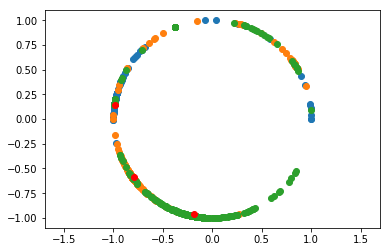

In [104]:
mean = np.zeros((10,2))
nb = np.zeros(10)
y_int = y_train
# y_train = y_train.astype(int)
# y_int = np.empty(len(y_train),dtype=int)
# for i in range(len(y_train)):
#     idx = 0
#     while (y_train[i][idx]!=1):
#         idx += 1
#     y_int[i] = int(idx)

for i in range(len(predict)):
    mean[y_int[i]] += predict[i]
    nb[y_int[i]] += 1

for i in range(len(mean)):
    mean[i] /= nb[i]
print(mean)

std_vect = np.zeros((10,2)) + mean
std = np.zeros(10)
for i in range(len(predict)):
    std[y_int[i]] += np.sum(np.square(predict[i]-mean))

for i in range(len(mean)):
    std[i] /= nb[i]
print(np.sqrt(std))

plt.axis('equal')
n = 3
for i in range(n):
    y = predict[np.equal(i,y_int)]
    plt.plot(y[:,0],y[:,1],'o')
plt.plot(mean[:n,0],mean[:n,1],'ro')